# In this notebook, a Siamese neural network is implemented, working on the basis of embedding for each of the texts.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Activation, Input, Lambda, Dropout, GlobalMaxPooling1D, Flatten, Conv1D, Dense, Dot
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score
print(tf.__version__)

2.8.0


In [2]:
def dist(vectors):
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def create_base_network(input_shape):
    seq = tf.keras.Sequential(name="Dense_Dropout_Dense")
    seq.add(Dense(375,activation="relu"))
    seq.add(Dropout(0.1))
    seq.add(Dense(175,activation="relu"))
    return seq

def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    return loss

## Preparing data for the model

In [3]:
df_first=joblib.load(open('df_final.joblib',"rb"))
df_first.head(2)

,text,label,split_text,word_count,sentence_vec,tr_key_words,key_words,key_vecs
0,андрей торопин криптовалютный инвестор совмест...,0,"[андрей, торопин, криптовалютный, инвестор, со...",113,"[0.31115916, -0.18865412, 0.4612622, -0.250920...","[[[0.064515114, 0.06818485, 0.068751454, 0.068...","[торговать биржа иметь, инвестор свой, инвести...","[[0.24219744, -0.20182237, 0.3212388, -0.06110..."
1,дорогой партнёр отличный новость сегодня июль ...,0,"[дорогой, партнёр, отличный, новость, сегодня,...",46,"[0.01884312, 0.07527621, 0.31362343, 0.2010696...","[[[0.22614872, 0.2874428, 0.30254436, 0.304069...","[погодаев елена ватлашов, команда ссылка транс...","[[0.16501789, -0.073621735, 0.19060352, 0.2858..."


In [4]:
df_first=df_first.drop(columns=["text","split_text","word_count","tr_key_words","key_words","key_vecs"])
df_first.head(2)

,label,sentence_vec
0,0,"[0.31115916, -0.18865412, 0.4612622, -0.250920..."
1,0,"[0.01884312, 0.07527621, 0.31362343, 0.2010696..."


In [5]:
train_df_neg=df_first[df_first.label==0].sentence_vec[:45].values
train_df_pos=df_first[df_first.label==1].sentence_vec[:45].values
test_df_neg=df_first[df_first.label==0].sentence_vec[45:50].values
test_df_pos=df_first[df_first.label==1].sentence_vec[45:50].values
assert train_df_neg.shape==train_df_pos.shape
assert test_df_neg.shape==test_df_pos.shape
print(train_df_neg.shape,train_df_pos.shape,test_df_neg.shape,test_df_pos.shape)

(45,) (45,) (5,) (5,)


In [6]:
# 1 - both texts are fraudulent, 0 - one is fraudulent, the other is not
train_labels_genuine=[1.]*(train_df_neg.shape[0]*train_df_neg.shape[0])
train_vec_pairs_genuine=[]
for i in range(train_df_neg.shape[0]):
    for j in range(train_df_neg.shape[0]):
        train_vec_pairs_genuine.append([train_df_neg[i],train_df_neg[j]])

train_labels_imposite=[0.]*(train_df_neg.shape[0]*train_df_pos.shape[0])
train_vec_pairs_imposite=[]
for i in range(train_df_neg.shape[0]):
    for j in range(train_df_pos.shape[0]):
        train_vec_pairs_imposite.append([train_df_neg[i],train_df_pos[j]])
       
        
train_X=train_vec_pairs_genuine+train_vec_pairs_imposite
train_y=train_labels_genuine+train_labels_imposite

tmp_df=pd.DataFrame({"x":train_X,"y":train_y})
tmp_df=tmp_df.sample(frac=1,ignore_index=True)

train_X=np.array([np.array(i) for i in tmp_df.x.values])
train_y=tmp_df.y.values

print(train_X.shape,train_y.shape)

(4050, 2, 768) (4050,)


In [7]:
# 1 - both texts are fraudulent, 0 - one is fraudulent, the other is not
test_labels_genuine=[1.]*(test_df_neg.shape[0]*test_df_neg.shape[0])
test_vec_pairs_genuine=[]
for i in range(test_df_neg.shape[0]):
    for j in range(test_df_neg.shape[0]):
        test_vec_pairs_genuine.append([test_df_neg[i],test_df_neg[j]])

test_labels_imposite=[0.]*(test_df_neg.shape[0]*test_df_pos.shape[0])
test_vec_pairs_imposite=[]
for i in range(test_df_neg.shape[0]):
    for j in range(test_df_pos.shape[0]):
        test_vec_pairs_imposite.append([test_df_neg[i],test_df_pos[j]])
       
        
test_X=test_vec_pairs_genuine+test_vec_pairs_imposite
test_y=test_labels_genuine+test_labels_imposite

tmp_df=pd.DataFrame({"x":test_X,"y":test_y})
tmp_df=tmp_df.sample(frac=1,ignore_index=True)

test_X=np.array([np.array(i) for i in tmp_df.x.values])
test_y=tmp_df.y.values

print(test_X.shape,test_y.shape)

(50, 2, 768) (50,)


## Model Assembly

In [8]:
input_dim = train_X.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = create_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(dist, output_shape=dist_output_shape,name="euclidean_distance")([feat_vecs_a, feat_vecs_b])
output = Activation(tf.keras.activations.sigmoid)(distance)

model = tf.keras.Model(inputs=[img_a, img_b], outputs=output)

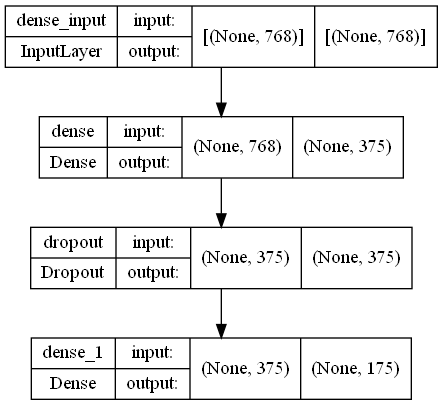

In [9]:
tf.keras.utils.plot_model(base_network,show_shapes=True)

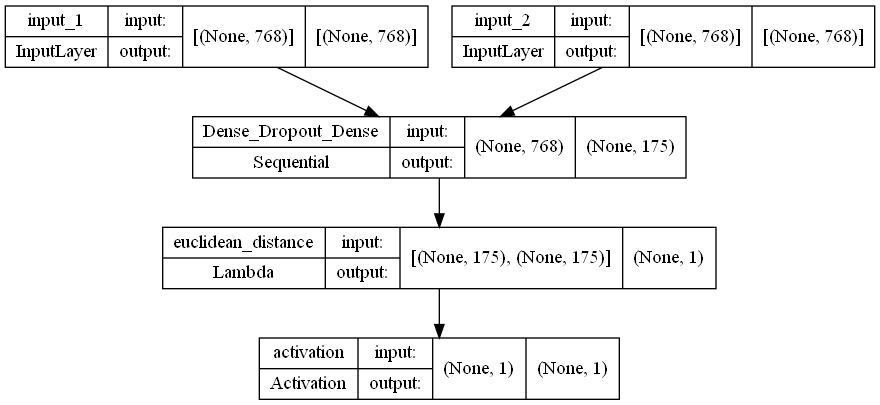

In [10]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [11]:
model.compile(loss=contrastive_loss, optimizer='adam')
history=model.fit([train_X[:, 0], train_X[:, 1]], train_y, verbose=1, epochs=25)

Epoch 1/25
127/127 [==============================] - 1s 4ms/step - loss: 0.1741
Epoch 2/25
127/127 [==============================] - 0s 4ms/step - loss: 0.1393
Epoch 3/25
127/127 [==============================] - 0s 4ms/step - loss: 0.1283
Epoch 4/25
127/127 [==============================] - 0s 4ms/step - loss: 0.1263
Epoch 5/25
127/127 [==============================] - 0s 3ms/step - loss: 0.1254
Epoch 6/25
127/127 [==============================] - 0s 3ms/step - loss: 0.1252
Epoch 7/25
127/127 [==============================] - 0s 3ms/step - loss: 0.1252
Epoch 8/25
127/127 [==============================] - 0s 3ms/step - loss: 0.1275
Epoch 9/25
127/127 [==============================] - 0s 4ms/step - loss: 0.1262
Epoch 10/25
127/127 [==============================] - 0s 3ms/step - loss: 0.1252
Epoch 11/25
127/127 [==============================] - 0s 4ms/step - loss: 0.1252
Epoch 12/25
127/127 [==============================] - 0s 3ms/step - loss: 0.1251
Epoch 13/25
127/127 [====

# Measurement of metrics

In [12]:
# Train
pred_train = model.predict([train_X[:, 0], train_X[:, 1]]).reshape(train_y.shape)
pred_train=np.where(pred_train > 0.99, 0., 1.)
acc_train=accuracy_score(pred_train,train_y)
print(f"Accuracy in training: {round(acc_train*100,2)}%")

Accuracy in training: 83.33%


In [13]:
# Test
pred_test = model.predict([test_X[:, 0], test_X[:, 1]]).reshape(test_y.shape)
pred_test=np.where(pred_test > 0.99, 0., 1.)
acc_test=accuracy_score(pred_test,test_y)
print(f"Accuracy on the test: {round(acc_test*100,2)}%")

Accuracy on the test: 70.0%


In [14]:
from sklearn.metrics import f1_score
f1_score(pred_train,train_y)

0.8571428571428571

In [15]:
f1_score(pred_test,test_y)

0.7692307692307693